# requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras as ks
import kerastuner as kt
import tensorflow as tf

In [2]:
from keras.preprocessing.image import ImageDataGenerator

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.__version__

'2.4.1'

In [5]:
from keras import backend as K

In [6]:
plt.rcParams["figure.figsize"] = [20, 10] 
plt.rcParams["axes.grid"]=True
plt.rcParams["font.size"]=16

# EDA, data augmentation 

In [60]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  rotation_range=1,
                                  zoom_range=[0.95,1.0],
                                  brightness_range=[0.5,1])
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory('data/Train/',
                                         batch_size=32)
validation_generator = validation_datagen.flow_from_directory('data/Validation/',
                                         batch_size=32)
test_generator = test_datagen.flow_from_directory('data/Test/',
                                        batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


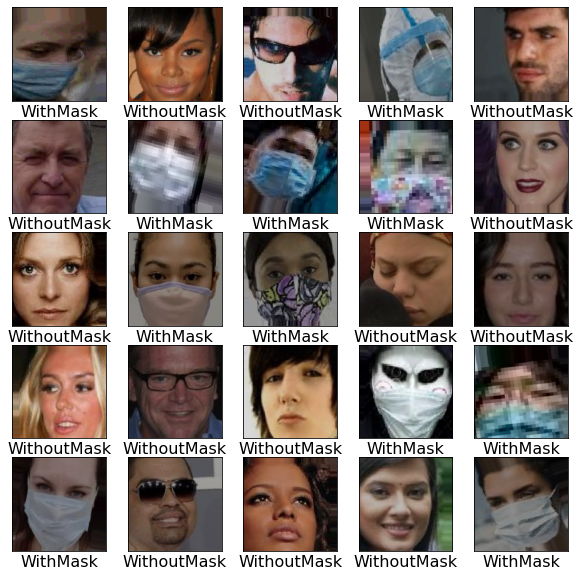

In [9]:
class_names = {v:k for k,v in train_generator.class_indices.items()}
images,labels = next(iter(train_generator))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[labels[i][1]])

plt.show()

In [10]:
def get_model_report(history):
    single_history_df = pd.DataFrame(history.history)
    display(single_history_df.style.background_gradient())
    single_history_df[["AUC",
                   "val_AUC"]].plot()
    single_history_df[["Precision",
                   "val_Precision",
                   "Recall",
                   "val_Recall"]].plot()
    single_history_df[["loss",
                   "val_loss"]].plot()

# Model 

Спочатку застосуємо просто приблизний baseline і подивимося на його результати

In [11]:
inputs = tf.keras.Input(shape = (256, 256, 3))
x = inputs
for i in range(4):
    for _ in range(2):
        x = tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(2,activation="softmax")(x)
model = tf.keras.Model(inputs,outputs)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[ks.metrics.CategoricalAccuracy(),
                       ks.metrics.AUC(),
                       ks.metrics.Precision(),
                       ks.metrics.Recall()])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256, 256, 32)      0     

In [13]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/best_model.h5',
        monitor='val_loss',
        mode="min"),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/tboard')
]

In [14]:
model.fit(train_generator,epochs=15,validation_data=validation_generator,
          callbacks = my_callbacks)

Epoch 1/15
313/313 [==============================] - 287s 883ms/step - loss: 2.0084 - categorical_accuracy: 0.8200 - auc: 0.8617 - precision: 0.8200 - recall: 0.8200 - val_loss: 1.5344 - val_categorical_accuracy: 0.6875 - val_auc: 0.7752 - val_precision: 0.6875 - val_recall: 0.6875
Epoch 2/15
313/313 [==============================] - 358s 1s/step - loss: 0.4299 - categorical_accuracy: 0.9324 - auc: 0.9659 - precision: 0.9324 - recall: 0.9324 - val_loss: 0.4617 - val_categorical_accuracy: 0.9050 - val_auc: 0.9494 - val_precision: 0.9050 - val_recall: 0.9050
Epoch 3/15
313/313 [==============================] - 356s 1s/step - loss: 0.3073 - categorical_accuracy: 0.9418 - auc: 0.9779 - precision: 0.9418 - recall: 0.9418 - val_loss: 0.1385 - val_categorical_accuracy: 0.9575 - val_auc: 0.9851 - val_precision: 0.9575 - val_recall: 0.9575
Epoch 4/15
313/313 [==============================] - 282s 902ms/step - loss: 0.1914 - categorical_accuracy: 0.9525 - auc: 0.9814 - precision: 0.9525 - re

Як бачимо, навіть простий підхід кращий ніж полнозвязний перцептрон в попередній роботі. Спробуємо застосувати гіпертюнер

# hypertuned

In [134]:
train_generator = train_datagen.flow_from_directory('data/Train/',
                                         batch_size=16)
validation_generator = validation_datagen.flow_from_directory('data/Validation/',
                                         batch_size=16)
test_generator = test_datagen.flow_from_directory('data/Test/',
                                        batch_size=16)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


Спробуємо застосувати гіпертюнер. Буде проводитися пошук не тільки гіперпараметрів, а й фактично архітектури моделі через кількість блоків conv

In [135]:
hp = kt.HyperParameters()
hp.Float('learning_rate',1e-4,1e-1)
hp.Float("dropout",0,1)
hp.Int('conv_blocks',2,4)
hp.Int('dense_hidden_size',8,512,sampling="log")

8

In [136]:
def build_model(hp:kt.HyperParameters):
    inputs = tf.keras.Input(shape = (256, 256, 3))
    x = inputs
    for i in range(hp.get("conv_blocks")):
        filters=hp.Int('filters_'+str(i),16,64,step=16)
        for _ in range(2):
            x = tf.keras.layers.Conv2D(
                filters,kernel_size=(3,3),
                padding="same")(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
        if hp.Choice('pooling_'+str(i),['avg','max'])=="max":
            x = tf.keras.layers.MaxPool2D()(x)
        else:
            x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.Dense(hp.get("dense_hidden_size"))(x)
    x = tf.keras.layers.Dropout(hp.get("dropout"))(x)
    outputs = tf.keras.layers.Dense(2,activation="softmax")(x)
    model = tf.keras.Model(inputs,outputs)
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(
                      learning_rate=hp.get('learning_rate')),
                  metrics=["accuracy"])
    return model

In [137]:
!rm -rf main_dir

In [138]:
!rm -rf logs

In [139]:
ls

data/  lab_3.ipynb  models/


In [140]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     seed=0,
                     max_epochs=100,
                     hyperband_iterations=7,
                     hyperparameters=hp,
                     directory='main_dir',
                     project_name='face_mask_detection')

In [141]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/tboard')
]

In [142]:
tuner.search(train_generator,
             validation_data=validation_generator,
             epochs=50,
             callbacks=my_callbacks)

Trial 182 Complete [00h 16m 57s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.9925000071525574
Total elapsed time: 09h 55m 27s

Search: Running Trial #183

Hyperparameter    |Value             |Best Value So Far 
learning_rate     |0.035853          |0.0013435         
dropout           |0.88103           |0.35516           
conv_blocks       |3                 |3                 
dense_hidden_size |60                |236               
filters_0         |32                |48                
pooling_0         |avg               |max               
filters_1         |32                |32                
pooling_1         |max               |avg               
filters_2         |32                |32                
pooling_2         |max               |max               
filters_3         |48                |16                
pooling_3         |max               |avg               
tuner/epochs      |4                 |100               
tuner/initial_e...|0                 |34    

KeyboardInterrupt: 

Keyboard interrupt був зроблений спеціально. Тюнер рахувався 2 дні і 9 годин, і було досягнуто 0.9925000071525574 accuracy на валідації. На цьому було вирішено припинити пошук і перейти до пункту з inception

In [143]:
best_model = tuner.get_best_models()[0]

In [146]:
best_model.evaluate(validation_generator)

50/50 [==============================] - 7s 131ms/step - loss: 0.0289 - accuracy: 0.9925


[0.028904028236865997, 0.9925000071525574]

In [147]:
best_model.evaluate(test_generator)

62/62 [==============================] - 8s 132ms/step - loss: 0.0386 - accuracy: 0.9909


[0.038586847484111786, 0.9909273982048035]

Тобто було отримано 0.9925 accuracy на валідації та 0.99 accuracy на тесті 

In [148]:
best_model.save("./models/best_model.h5")

In [149]:
tuner.results_summary()

Results summary
Results in main_dir/face_mask_detection
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0013435498131650527
dropout: 0.35516002614529363
conv_blocks: 3
dense_hidden_size: 236
filters_0: 48
pooling_0: max
filters_1: 32
pooling_1: avg
filters_2: 32
pooling_2: max
filters_3: 16
pooling_3: avg
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0c41420ce10cf21cb3cb8100e48cf227
Score: 0.9925000071525574
Trial summary
Hyperparameters:
learning_rate: 0.0013435498131650527
dropout: 0.35516002614529363
conv_blocks: 3
dense_hidden_size: 236
filters_0: 48
pooling_0: max
filters_1: 32
pooling_1: avg
filters_2: 32
pooling_2: max
filters_3: 16
pooling_3: avg
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 7d20219d0ba334f1194f091befee43a2
Score: 0.987500011920929
Trial summary
Hyperparameters:
learning_rate: 0.0022262216875668715
dropout

In [151]:
tuner.save()

# inception

In [161]:
inception = tf.keras.applications.InceptionV3(weights = None,
                                              input_shape=(256,256,3),
                                              classes=2)

In [162]:
my_inception_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/tboard_inception')
]

In [163]:
inception.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

In [164]:
inception.fit(train_generator,epochs=30,
              callbacks = my_inception_callbacks,
              validation_data=validation_generator)

Epoch 1/30
625/625 [==============================] - 550s 870ms/step - loss: 0.3925 - accuracy: 0.8665 - val_loss: 0.3206 - val_accuracy: 0.8888
Epoch 2/30
625/625 [==============================] - 534s 855ms/step - loss: 0.1881 - accuracy: 0.9318 - val_loss: 0.3781 - val_accuracy: 0.8175
Epoch 3/30
625/625 [==============================] - 539s 862ms/step - loss: 0.1525 - accuracy: 0.9456 - val_loss: 0.1430 - val_accuracy: 0.9350
Epoch 4/30
625/625 [==============================] - 486s 777ms/step - loss: 0.1470 - accuracy: 0.9542 - val_loss: 0.2223 - val_accuracy: 0.9275
Epoch 5/30
625/625 [==============================] - 534s 854ms/step - loss: 0.1340 - accuracy: 0.9548 - val_loss: 0.2447 - val_accuracy: 0.9200
Epoch 6/30
625/625 [==============================] - 536s 857ms/step - loss: 0.0988 - accuracy: 0.9663 - val_loss: 0.1035 - val_accuracy: 0.9675
Epoch 7/30
625/625 [==============================] - 539s 861ms/step - loss: 0.0872 - accuracy: 0.9700 - val_loss: 0.0851 -

In [165]:
inception.evaluate(test_generator)

62/62 [==============================] - 13s 212ms/step - loss: 0.0243 - accuracy: 0.9929


[0.024255219846963882, 0.992943525314331]

Судячи з метрик, inception краще за звичайну модель, і це не дивно, враховуючи його непросту структуру 

In [166]:
inception.save("./models/inception.h5")

# transfer learning

Тепер спробуємо застосувати transfer learning

In [187]:
inception_transfer = tf.keras.applications.InceptionV3(input_shape=(256,256,3),
                                                       include_top=False,
                                                       input_tensor = inputs)
for layer in inception_transfer.layers:
    layer.trainable = False
    
x = tf.keras.layers.Flatten()(inception_transfer.output)
x = tf.keras.layers.Dense(128,activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2,activation="softmax")(x)

model_transfer = tf.keras.Model(inception_transfer.input,x)

In [188]:
model_transfer.compile(optimizer=tf.keras.optimizers.Adam(),
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics = ["accuracy"])

In [189]:
model_transfer.fit(train_generator,validation_data=validation_generator,
                   epochs=5)

Epoch 1/5
625/625 [==============================] - 226s 356ms/step - loss: 0.7121 - accuracy: 0.9779 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2/5
625/625 [==============================] - 250s 400ms/step - loss: 0.0220 - accuracy: 0.9956 - val_loss: 8.1272e-05 - val_accuracy: 1.0000
Epoch 3/5
625/625 [==============================] - 258s 413ms/step - loss: 0.0312 - accuracy: 0.9959 - val_loss: 0.0026 - val_accuracy: 0.9987
Epoch 4/5
625/625 [==============================] - 223s 355ms/step - loss: 0.0202 - accuracy: 0.9959 - val_loss: 0.0034 - val_accuracy: 0.9987
Epoch 5/5
625/625 [==============================] - 233s 373ms/step - loss: 0.0457 - accuracy: 0.9946 - val_loss: 0.0026 - val_accuracy: 0.9987


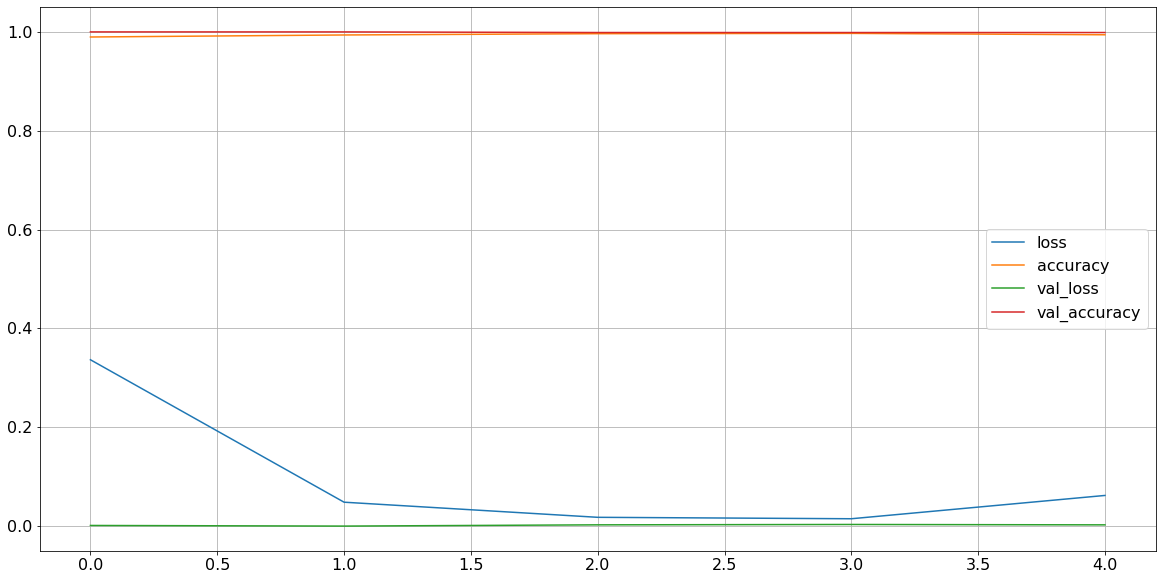

In [190]:
pd.DataFrame(model_transfer.history.history).plot()

# test

In [195]:
X_test,y_test = next(test_generator)

## Simple model test

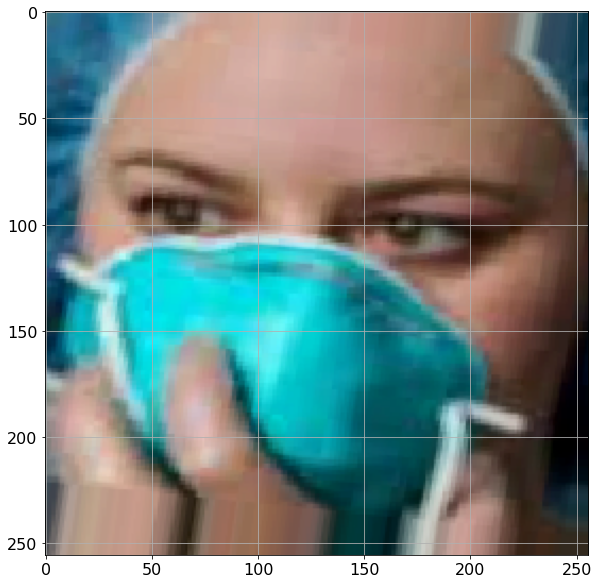

With    Mask proba:0.9998911619186401
Without Mask proba:0.00010887583630392328


In [201]:
image_arr = X_test[3]
simple_model_predictions_with_mask = best_model.predict(np.array([image_arr]))    
plt.imshow(image_arr)
plt.show()
print(f"With    Mask proba:{ simple_model_predictions_with_mask[0][0]}")
print(f"Without Mask proba:{ simple_model_predictions_with_mask[0][1]}")

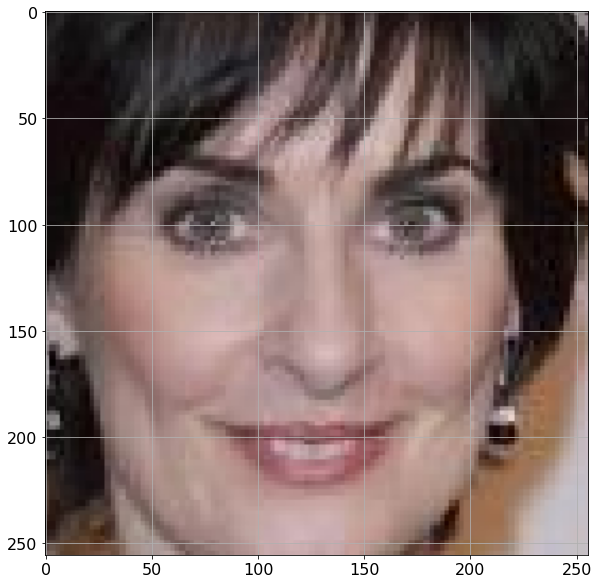

With    Mask proba:1.2208174666739069e-06
Without Mask proba:0.9999988079071045


In [202]:
image_arr = X_test[5]
simple_model_predictions_without_mask = best_model.predict(np.array([image_arr]))    
plt.imshow(image_arr)
plt.show()
print(f"With    Mask proba:{ simple_model_predictions_without_mask[0][0]}")
print(f"Without Mask proba:{ simple_model_predictions_without_mask[0][1]}")

## Inception

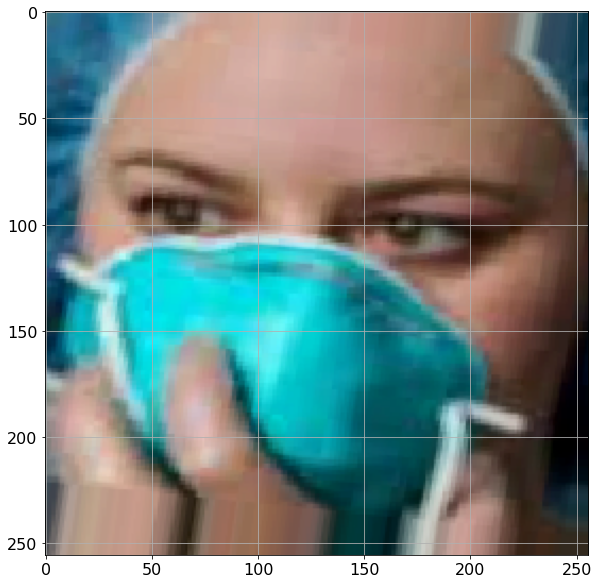

With    Mask proba:1.0
Without Mask proba:6.5358061185349925e-09


In [203]:
image_arr = X_test[3]
inception_predictions_with_mask = inception.predict(np.array([image_arr]))    
plt.imshow(image_arr)
plt.show()
print(f"With    Mask proba:{ inception_predictions_with_mask[0][0]}")
print(f"Without Mask proba:{ inception_predictions_with_mask[0][1]}")

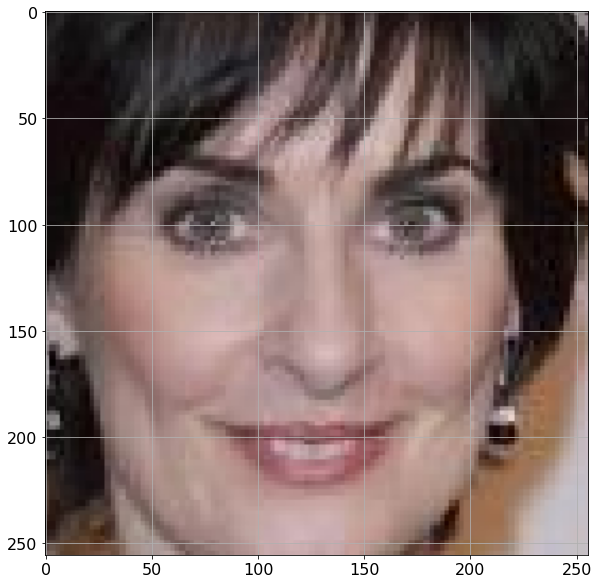

With    Mask proba:0.000116026058094576
Without Mask proba:0.9998840093612671


In [204]:
image_arr = X_test[5]
inception_predictions_without_mask = inception.predict(np.array([image_arr]))    
plt.imshow(image_arr)
plt.show()
print(f"With    Mask proba:{ inception_predictions_without_mask[0][0]}")
print(f"Without Mask proba:{ inception_predictions_without_mask[0][1]}")

## inception transfer

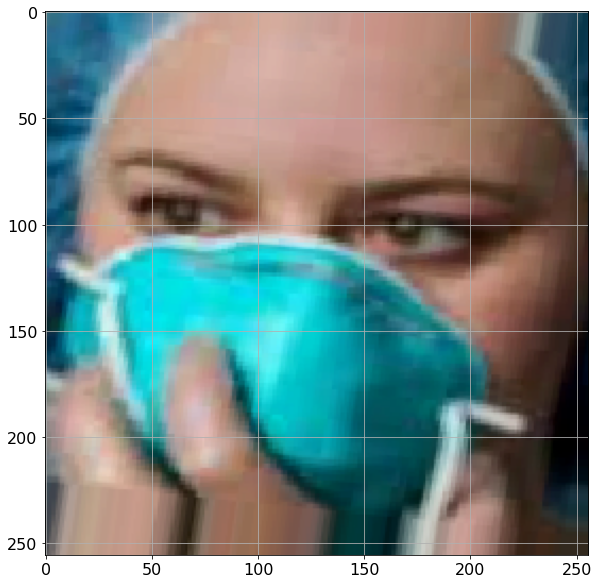

With    Mask proba:1.0
Without Mask proba:8.74968771205809e-22


In [205]:
image_arr = X_test[3]
inception_transfer_predictions_with_mask = model_transfer.predict(np.array([image_arr]))    
plt.imshow(image_arr)
plt.show()
print(f"With    Mask proba:{ inception_transfer_predictions_with_mask[0][0]}")
print(f"Without Mask proba:{ inception_transfer_predictions_with_mask[0][1]}")

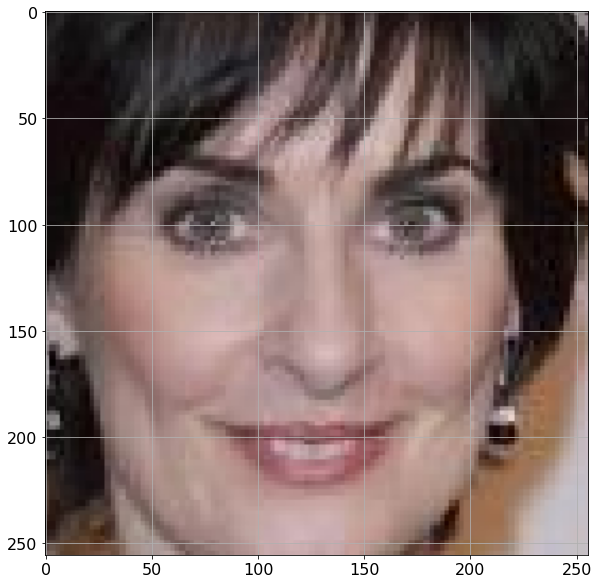

With    Mask proba:0.0
Without Mask proba:1.0


In [206]:
image_arr = X_test[5]
inception_transfer_predictions_without_mask = model_transfer.predict(np.array([image_arr]))    
plt.imshow(image_arr)
plt.show()
print(f"With    Mask proba:{ inception_transfer_predictions_without_mask[0][0]}")
print(f"Without Mask proba:{ inception_transfer_predictions_without_mask[0][1]}")

## comparison

Images before

image with mask comparison 

In [213]:
pd.DataFrame({"simple_model":simple_model_predictions_with_mask[0],
              "inception":inception_predictions_with_mask[0],
              "inception_transfer":inception_transfer_predictions_with_mask[0]},
             index = ["with_mask_proba","without_mask_proba"])

,simple_model,inception,inception_transfer
with_mask_proba,0.999891,1.000000e+00,1.000000e+00
without_mask_proba,0.000109,6.535806e-09,8.749688e-22


In [214]:
pd.DataFrame({"simple_model":simple_model_predictions_without_mask[0],
              "inception":inception_predictions_without_mask[0],
              "inception_transfer":inception_transfer_predictions_without_mask[0]},
             index = ["with_mask_proba","without_mask_proba"])

,simple_model,inception,inception_transfer
with_mask_proba,0.000001,0.000116,0.0
without_mask_proba,0.999999,0.999884,1.0


all test dataset

In [215]:
test_metrics = pd.DataFrame({"simple_model":best_model.evaluate(test_generator),
              "inception":inception.evaluate(test_generator),
              "inception_transfer":model_transfer.evaluate(test_generator)},
                            index = ["loss","accuracy"])
test_metrics

62/62 [==============================] - 13s 215ms/step - loss: 0.0137 - accuracy: 0.9990


,simple_model,inception,inception_transfer
loss,0.038587,0.024255,0.013673
accuracy,0.990927,0.992944,0.998992


Висновок: Як бачимо, transfer learning виявився найефективнішим способом. В свою чергу, не варто забувати, що і базову модель для трансфер лернінгу  отримали шляхом створення нової нейромережі, а тому треба вміти конструювати і звичайні моделі з нуля.